# Time-Series Analysis using LSTM: Dhaka Tribune

## Highlights

* Dataset: Dhaka Tribune 2021 Dataset.
* Training Period: 2021-04-23 to 2021-06-18
* Test/Validation Period: 2021-06-19 to 2021-06-26

Author: Sumaia Parveen Shupti

Created on: 07/07/2021

Updated on: 07/10/2021



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

### Load & Preprocess Dataset

In [2]:
df = pd.read_csv('../input/dhakatribunecomplete/Dhaka Tribune Complete Data.csv')
df['Accident date'] = pd.to_datetime(df['Accident date'])

df = df[['Accident date', 'Deaths']]
df.columns = ['Period', 'Deaths']
df = df.sort_values(by = 'Period')
df = df.reset_index(drop = True).set_index('Period').resample('1D').sum()
df = df.reset_index()
df['Period'] = df['Period'].dt.date
df['Deaths'] = df['Deaths'].fillna(0)
df = df.set_index('Period')
df = df[1652:].reset_index()
df['Period'] = pd.to_datetime(df['Period'])
df

,Period,Deaths
0,2021-01-01,11.0
1,2021-01-02,0.0
2,2021-01-03,7.0
3,2021-01-04,0.0
4,2021-01-05,0.0
...,...,...
172,2021-06-22,0.0
173,2021-06-23,3.0
174,2021-06-24,0.0
175,2021-06-25,0.0


In [3]:
df.dtypes

Period    datetime64[ns]
Deaths           float64
dtype: object

### Splitting into Train & Test Sets

In [4]:
start_ = df.Period.max()
end_ = df.Period.min()

test_end = df.Period.max()
test_start = df.Period.max() - timedelta(days = 7)

train_end = test_start - timedelta(days = 1)
train_start = train_end - timedelta(days = 57)

print('Dataset Start Date: {}'.format(start_))
print('Dataset End Date: {}'.format(end_))
print (' ')
print('Train Set Start Date: {}'.format(train_start))
print('Train Set End Date: {}'.format(train_end))
print (' ')
print('Test Set Start Date: {}'.format(test_start))
print('Test Set End Date: {}'.format(test_end))
print (' ')

Dataset Start Date: 2021-06-26 00:00:00
Dataset End Date: 2021-01-01 00:00:00
 
Train Set Start Date: 2021-04-22 00:00:00
Train Set End Date: 2021-06-18 00:00:00
 
Test Set Start Date: 2021-06-19 00:00:00
Test Set End Date: 2021-06-26 00:00:00
 


In [5]:
mask = (df.Period > train_start) & (df.Period <= train_end)
train = df.loc[mask]

mask = (df.Period >= test_start) & (df.Period <= test_end)
test = df.loc[mask]

In [6]:
train.tail()

,Period,Deaths
164,2021-06-14,0.0
165,2021-06-15,0.0
166,2021-06-16,6.0
167,2021-06-17,0.0
168,2021-06-18,3.0


In [7]:
test.head()

,Period,Deaths
169,2021-06-19,7.0
170,2021-06-20,0.0
171,2021-06-21,0.0
172,2021-06-22,0.0
173,2021-06-23,3.0


In [8]:
d = pd.concat([train, test])
d = d.reset_index()
d

,index,Period,Deaths
0,112,2021-04-23,0.0
1,113,2021-04-24,0.0
2,114,2021-04-25,0.0
3,115,2021-04-26,0.0
4,116,2021-04-27,0.0
...,...,...,...
60,172,2021-06-22,0.0
61,173,2021-06-23,3.0
62,174,2021-06-24,0.0
63,175,2021-06-25,0.0


### Transform the data into a time series problem

In [9]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### We will use the present day and the last 3 days data to forecast 1 day's results ahead

In [10]:
window = 3
lag = 1
series = series_to_supervised(d.drop('Period', axis=1), window=window, lag=lag)
series

,index(t-3),Deaths(t-3),index(t-2),Deaths(t-2),index(t-1),Deaths(t-1),index(t),Deaths(t),index(t+1),Deaths(t+1)
3,112.0,0.0,113.0,0.0,114.0,0.0,115,0.0,116.0,0.0
4,113.0,0.0,114.0,0.0,115.0,0.0,116,0.0,117.0,0.0
5,114.0,0.0,115.0,0.0,116.0,0.0,117,0.0,118.0,1.0
6,115.0,0.0,116.0,0.0,117.0,0.0,118,1.0,119.0,0.0
7,116.0,0.0,117.0,0.0,118.0,1.0,119,0.0,120.0,10.0
...,...,...,...,...,...,...,...,...,...,...
59,168.0,3.0,169.0,7.0,170.0,0.0,171,0.0,172.0,0.0
60,169.0,7.0,170.0,0.0,171.0,0.0,172,0.0,173.0,3.0
61,170.0,0.0,171.0,0.0,172.0,0.0,173,3.0,174.0,0.0
62,171.0,0.0,172.0,0.0,173.0,3.0,174,0.0,175.0,0.0


In [11]:
lag_size = 1 

# Label
labels_col = 'Deaths(t+%d)' % lag_size
labels = series[[labels_col]]
series = series.drop(labels_col, axis=1)
series

,index(t-3),Deaths(t-3),index(t-2),Deaths(t-2),index(t-1),Deaths(t-1),index(t),Deaths(t),index(t+1)
3,112.0,0.0,113.0,0.0,114.0,0.0,115,0.0,116.0
4,113.0,0.0,114.0,0.0,115.0,0.0,116,0.0,117.0
5,114.0,0.0,115.0,0.0,116.0,0.0,117,0.0,118.0
6,115.0,0.0,116.0,0.0,117.0,0.0,118,1.0,119.0
7,116.0,0.0,117.0,0.0,118.0,1.0,119,0.0,120.0
...,...,...,...,...,...,...,...,...,...
59,168.0,3.0,169.0,7.0,170.0,0.0,171,0.0,172.0
60,169.0,7.0,170.0,0.0,171.0,0.0,172,0.0,173.0
61,170.0,0.0,171.0,0.0,172.0,0.0,173,3.0,174.0
62,171.0,0.0,172.0,0.0,173.0,3.0,174,0.0,175.0


In [12]:
labels

,Deaths(t+1)
3,0.0
4,0.0
5,1.0
6,0.0
7,10.0
...,...
59,0.0
60,3.0
61,0.0
62,0.0


In [13]:
X_train = series[:len(train)- window]
X_train

,index(t-3),Deaths(t-3),index(t-2),Deaths(t-2),index(t-1),Deaths(t-1),index(t),Deaths(t),index(t+1)
3,112.0,0.0,113.0,0.0,114.0,0.0,115,0.0,116.0
4,113.0,0.0,114.0,0.0,115.0,0.0,116,0.0,117.0
5,114.0,0.0,115.0,0.0,116.0,0.0,117,0.0,118.0
6,115.0,0.0,116.0,0.0,117.0,0.0,118,1.0,119.0
7,116.0,0.0,117.0,0.0,118.0,1.0,119,0.0,120.0
8,117.0,0.0,118.0,1.0,119.0,0.0,120,10.0,121.0
9,118.0,1.0,119.0,0.0,120.0,10.0,121,1.0,122.0
10,119.0,0.0,120.0,10.0,121.0,1.0,122,3.0,123.0
11,120.0,10.0,121.0,1.0,122.0,3.0,123,0.0,124.0
12,121.0,1.0,122.0,3.0,123.0,0.0,124,0.0,125.0


In [14]:
Y_train = labels[:len(train)- window]
Y_train

,Deaths(t+1)
3,0.0
4,0.0
5,1.0
6,0.0
7,10.0
8,1.0
9,3.0
10,0.0
11,0.0
12,4.0


In [15]:
X_valid = series[len(train)- window:]
X_valid

,index(t-3),Deaths(t-3),index(t-2),Deaths(t-2),index(t-1),Deaths(t-1),index(t),Deaths(t),index(t+1)
57,166.0,6.0,167.0,0.0,168.0,3.0,169,7.0,170.0
58,167.0,0.0,168.0,3.0,169.0,7.0,170,0.0,171.0
59,168.0,3.0,169.0,7.0,170.0,0.0,171,0.0,172.0
60,169.0,7.0,170.0,0.0,171.0,0.0,172,0.0,173.0
61,170.0,0.0,171.0,0.0,172.0,0.0,173,3.0,174.0
62,171.0,0.0,172.0,0.0,173.0,3.0,174,0.0,175.0
63,172.0,0.0,173.0,3.0,174.0,0.0,175,0.0,176.0


In [16]:
Y_valid = labels[len(train)- window:]
Y_valid

,Deaths(t+1)
57,0.0
58,0.0
59,0.0
60,3.0
61,0.0
62,0.0
63,2.0


In [17]:
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)

print('Train labels shape', Y_train.shape)
print('Validation labels shape', Y_valid.shape)

Train set shape (54, 9)
Validation set shape (7, 9)
Train labels shape (54, 1)
Validation labels shape (7, 1)


### Data Preprocess

* Reshape from [samples, timesteps] into [samples, timesteps, 1].

**Note: timestep = window + lag**

* In our case, window = 3, lag = 1.

In [18]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (54, 9, 1)
Validation set shape (7, 9, 1)


### Model Development: LSTM

In [19]:
epochs = 100
batch = 4
lr = 0.0003
adam = optimizers.Adam(lr)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [20]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mae', optimizer=adam)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1, callbacks=[es, mcp])

Epoch 1/100
2/2 [==============================] - 2s 786ms/step - loss: 8.9884 - val_loss: 11.2472

Epoch 00001: val_loss improved from inf to 11.24717, saving model to weights.h5
Epoch 2/100
2/2 [==============================] - 0s 112ms/step - loss: 7.3164 - val_loss: 8.0634

Epoch 00002: val_loss improved from 11.24717 to 8.06343, saving model to weights.h5
Epoch 3/100
2/2 [==============================] - 0s 114ms/step - loss: 5.0791 - val_loss: 4.8161

Epoch 00003: val_loss improved from 8.06343 to 4.81609, saving model to weights.h5
Epoch 4/100
2/2 [==============================] - 0s 115ms/step - loss: 3.2748 - val_loss: 2.2876

Epoch 00004: val_loss improved from 4.81609 to 2.28757, saving model to weights.h5
Epoch 5/100
2/2 [==============================] - 0s 120ms/step - loss: 2.3690 - val_loss: 1.4923

Epoch 00005: val_loss improved from 2.28757 to 1.49226, saving model to weights.h5
Epoch 6/100
2/2 [==============================] - 0s 126ms/step - loss: 2.7336 - val_

In [22]:
%%time
lstm_valid_pred = model_lstm.predict(X_valid_series)

CPU times: user 209 ms, sys: 4.13 ms, total: 213 ms
Wall time: 210 ms


In [23]:
comparison = test.copy()
comparison = comparison[:len(test)-lag]
comparison['Prediction'] = lstm_valid_pred
comparison = comparison.set_index('Period')
comparison.head()

,Deaths,Prediction
Period,,
2021-06-19,7.0,0.119152
2021-06-20,0.0,0.713814
2021-06-21,0.0,0.024636
2021-06-22,0.0,-0.052182
2021-06-23,3.0,-0.006084


In [24]:
%%time
lstm_train_pred = model_lstm.predict(X_train_series)

CPU times: user 45.5 ms, sys: 1.02 ms, total: 46.5 ms
Wall time: 42.3 ms


In [25]:
comparison_train = train.copy()
comparison_train = comparison_train[window:]
comparison_train['Prediction'] = lstm_train_pred
comparison_train = comparison_train.set_index('Period')
comparison_train.head()

,Deaths,Prediction
Period,,
2021-04-26,0.0,0.037201
2021-04-27,0.0,0.040820
2021-04-28,0.0,0.044423
2021-04-29,1.0,0.052600
2021-04-30,0.0,0.169337


### Visualization of Results

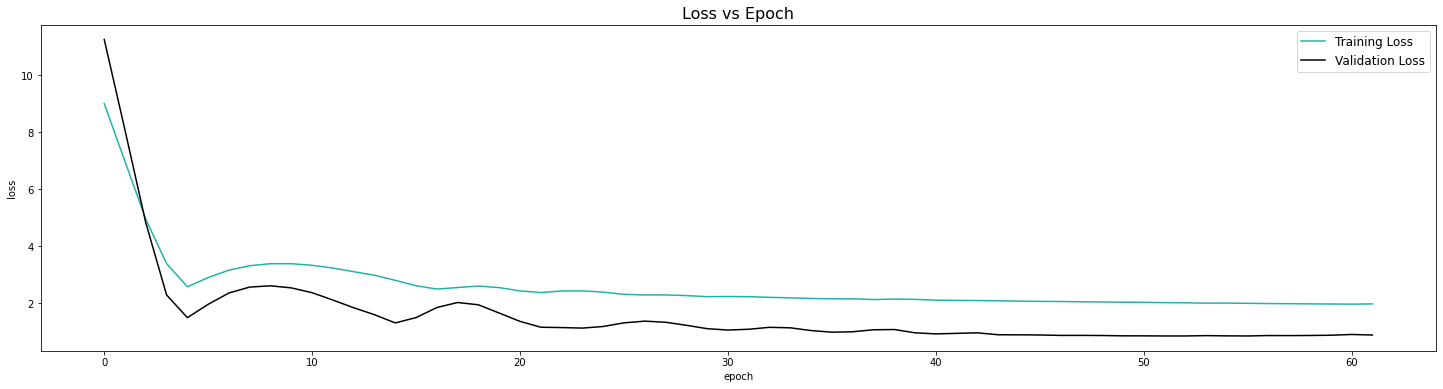

In [26]:
plt.rcParams["figure.figsize"] = [25, 6]

plt.plot(lstm_history.history['loss'], color = 'lightseagreen')
plt.plot(lstm_history.history['val_loss'], color = 'black')
plt.title('Loss vs Epoch', fontsize = 16)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='best', fontsize = 'large')
plt.show()

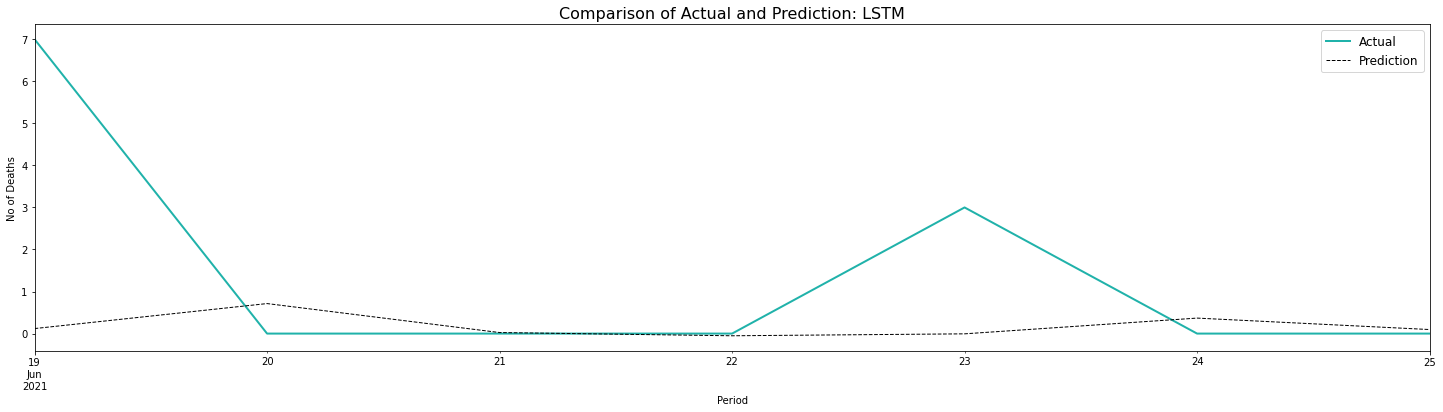

In [27]:
plt.rcParams["figure.figsize"] = [25, 6]

comparison.Deaths.plot(linewidth = 2, label = 'Actual', color = 'lightseagreen')
comparison.Prediction.plot(linewidth = 1, label = 'Prediction', color = 'black', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('No of Deaths')
plt.title('Comparison of Actual and Prediction: LSTM', fontsize = 16)
plt.show()

### Evaluation Metrics: Training Set

In [28]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison_train['Deaths'] - comparison_train['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison_train['Deaths']).mean() * 100
r2 = r2_score(comparison_train['Deaths'], comparison_train['Prediction'])

In [29]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 1.9256
Root Mean Square Error: 3.7002
Mean Absolute Percentage Error: inf
R2 Score: -0.2094


### Evaluation Metrics: Validation Set

In [30]:
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

errors = comparison['Deaths'] - comparison['Prediction']
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/comparison['Deaths']).mean() * 100
r2 = r2_score(comparison['Deaths'], comparison['Prediction'])

In [31]:
print('Mean Absolute Error: {:.4f}'.format(mae))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
print('R2 Score: {:.4f}'.format(r2))

Mean Absolute Error: 1.5917
Root Mean Square Error: 2.8546
Mean Absolute Percentage Error: inf
R2 Score: -0.3048


## Reference

* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/